In [1]:
!nvidia-smi

Wed May  3 02:41:20 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 531.41       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070         On | 00000000:01:00.0  On |                  N/A |
|  0%   44C    P8               28W / 220W|    489MiB /  8192MiB |      4%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip3 install opencv-python scikit-learn tqdm pandas
!apt-get -y install libgl1-mesa-glx

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgl1-mesa-glx is already the newest version (21.2.6-0ubuntu0.1~20.04.2).
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


# import

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras import regularizers
from keras import optimizers
from glob import glob
from tqdm import tqdm

# Preprocessing

In [4]:
dataset_path = "./dataset/img/img128/"

In [5]:
label_df = pd.read_csv('./dataset/original/trainLabels.csv')
label_df

,Id,Class
0,01kcPWA9K2BOxQeS5Rju,1
1,04EjIdbPV5e1XroFOpiN,1
2,05EeG39MTRrI6VY21DPd,1
3,05rJTUWYAKNegBk2wE8X,1
4,0AnoOZDNbPXIr2MRBSCJ,1
...,...,...
10863,KFrZ0Lop1WDGwUtkusCi,9
10864,kg24YRJTB8DNdKMXpwOH,9
10865,kG29BLiFYPgWtpb350sO,9
10866,kGITL4OJxYMWEQ1bKBiP,9


In [6]:
x = []
y = []

image_w = 128
image_h = 128

for idx, row in tqdm(label_df.iterrows()):
    img_path = f"./dataset/img/img128/{row['Id']}.png"
    malware_class = row['Class']
    
    img = cv2.imread(img_path)
    img = cv2.resize(img, None, 
                     fx=image_w/img.shape[1], 
                     fy=image_h/img.shape[0])
    img = img[:,:,0].reshape(image_w,image_h,1)
    
    x.append(img/255.)
    y.append(tf.keras.utils.to_categorical(malware_class-1,9))
    
x = np.array(x)
y = np.array(y)
    
train_img, val_img, train_label, val_label = train_test_split(x, 
                                                  y, 
                                                  stratify=y, 
                                                  test_size=0.2)

10868it [00:03, 3616.08it/s]


In [7]:
train_img.shape, val_img.shape, train_label.shape, val_label.shape

((8694, 128, 128, 1), (2174, 128, 128, 1), (8694, 9), (2174, 9))

# Dataset

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_img, train_label)).shuffle(buffer_size=100000).batch(128)
val_dataset = tf.data.Dataset.from_tensor_slices((val_img, val_label)).batch(128)

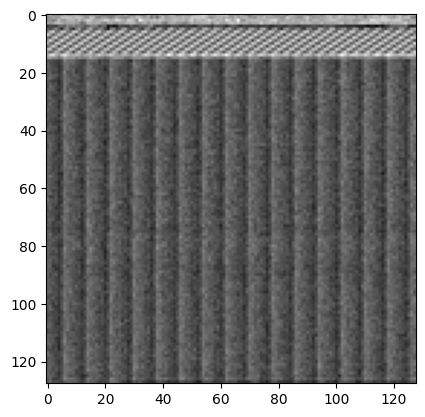

Label : [0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [9]:
img, label = next(iter(train_dataset))

plt.imshow(img[0], cmap='gray')
plt.show()

print(f"Label : {label[0]}")

# ResNet

In [10]:
class ResidualUnit(tf.keras.Model):
    def __init__(self, filter_in, filter_out, kernel_size):
        super(ResidualUnit, self).__init__()
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv1 = tf.keras.layers.Conv2D(filter_out, kernel_size, padding='same')
        
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filter_out, kernel_size, padding='same')
        
        if filter_in == filter_out:
            self.identity = lambda x: x
        else:
            self.identity = tf.keras.layers.Conv2D(filter_out, (1,1), padding='same')

    def call(self, x, mask=None):
        h = self.bn1(x)
        h = tf.nn.relu(h)
        h = self.conv1(h)
        
        h = self.bn2(h)
        h = tf.nn.relu(h)
        h = self.conv2(h)
        return self.identity(x) + h

In [11]:
class ResnetLayer(tf.keras.Model):
    def __init__(self, filter_in, filters, kernel_size):
        super(ResnetLayer, self).__init__()
        self.sequence = list()
        for f_in, f_out in zip([filter_in] + list(filters), filters):
            self.sequence.append(ResidualUnit(f_in, f_out, kernel_size))

    def call(self, x, training=False, mask=None):
        for unit in self.sequence:
            x = unit(x)
        return x

In [12]:
class ResNet(tf.keras.Model):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(50, (5, 5), 
                                            padding='same', 
                                            activation='relu', 
                                            input_shape=(128, 128, 1)
                                           )
        self.pool1 = tf.keras.layers.MaxPool2D((2, 2))
        
        self.res1 = ResnetLayer(35, (70, 70), (3, 3))
        self.pool2 = tf.keras.layers.MaxPool2D((2, 2))
        
        self.res2 = ResnetLayer(35, (70, 70), (3, 3))
        self.pool3 = tf.keras.layers.MaxPool2D((2, 2))
        
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(256, activation='relu')
        self.dense2 = tf.keras.layers.Dense(9, activation='softmax')
        
    def call(self, x, mask=None):
        x = self.conv1(x)
        x = self.pool1(x)
        
        x = self.res1(x)
        x = self.pool2(x)
        x = self.res2(x)
        x = self.pool3(x)
        
        x = self.flatten(x)
        x = self.dense1(x)
        return self.dense2(x)
        

In [13]:
malware_class = ResNet()
malware_class.build((None,128,128,1))

adam = optimizers.Adam(lr=0.0001)
malware_class.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
malware_class.summary()

Model: "res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  1300      
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 resnet_layer (ResnetLayer)  multiple                  168690    
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 resnet_layer_1 (ResnetLayer  multiple                 182770    
 )                                                               
                                                           

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
save_path = './model/malware_resnet128/'
checkpoint_path = save_path+"/model_{epoch}.ckpt"

# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1, period=1)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=0)

In [15]:
history = malware_class.fit(train_dataset, epochs=75, validation_data=val_dataset, callbacks=[cp_callback])

Epoch 1/75
68/68 [==============================] - 16s 172ms/step - loss: 0.6321 - accuracy: 0.8577 - val_loss: 2.6466 - val_accuracy: 0.0368
Epoch 2/75
68/68 [==============================] - 10s 145ms/step - loss: 0.1156 - accuracy: 0.9689 - val_loss: 3.6424 - val_accuracy: 0.0368
Epoch 3/75
68/68 [==============================] - 10s 144ms/step - loss: 0.0477 - accuracy: 0.9886 - val_loss: 3.5230 - val_accuracy: 0.0368
Epoch 4/75
68/68 [==============================] - 10s 144ms/step - loss: 0.0236 - accuracy: 0.9956 - val_loss: 3.4024 - val_accuracy: 0.0400
Epoch 5/75
12/68 [====>.........................] - ETA: 7s - loss: 0.0146 - accuracy: 0.9987

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

# Model Load and predict

In [15]:
epoch = 30
checkpoint_path = f"./model/malware_cnn128/model_{epoch}.ckpt"

malware_class = Simple_CNN()
malware_class.load_weights(checkpoint_path)
malware_class.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 50)      1300      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 50)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 70)        31570     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 70)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 70)        44170     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 70)      

In [16]:
loss, acc = malware_class.evaluate(val_dataset, verbose=1)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

9/9 [==============================] - 1s 41ms/step - loss: 0.1322 - accuracy: 0.9683
Restored model, accuracy: 96.83%


In [17]:
imgs = glob("./dataset/img/img128/*.png")
img = tf.io.read_file(imgs[0])
img = tf.io.decode_image(img)
img = tf.expand_dims(img,axis=0)
img.shape

TensorShape([1, 128, 128, 1])

In [18]:
prediction= malware_class.predict(img)
prediction

1/1 [==============================] - 0s 434ms/step


array([[0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)